<a href="https://colab.research.google.com/github/ZainULArfeen/covid-19-Classification/blob/master/covidClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tensorflow_datasets as tfd
import pathlib

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = "drive/MyDrive/FYP/dataset"

In [4]:

DATA_DIR = pathlib.Path(data_dir)

image_count = len(list(DATA_DIR.glob('*/*.png')))
image_count

435

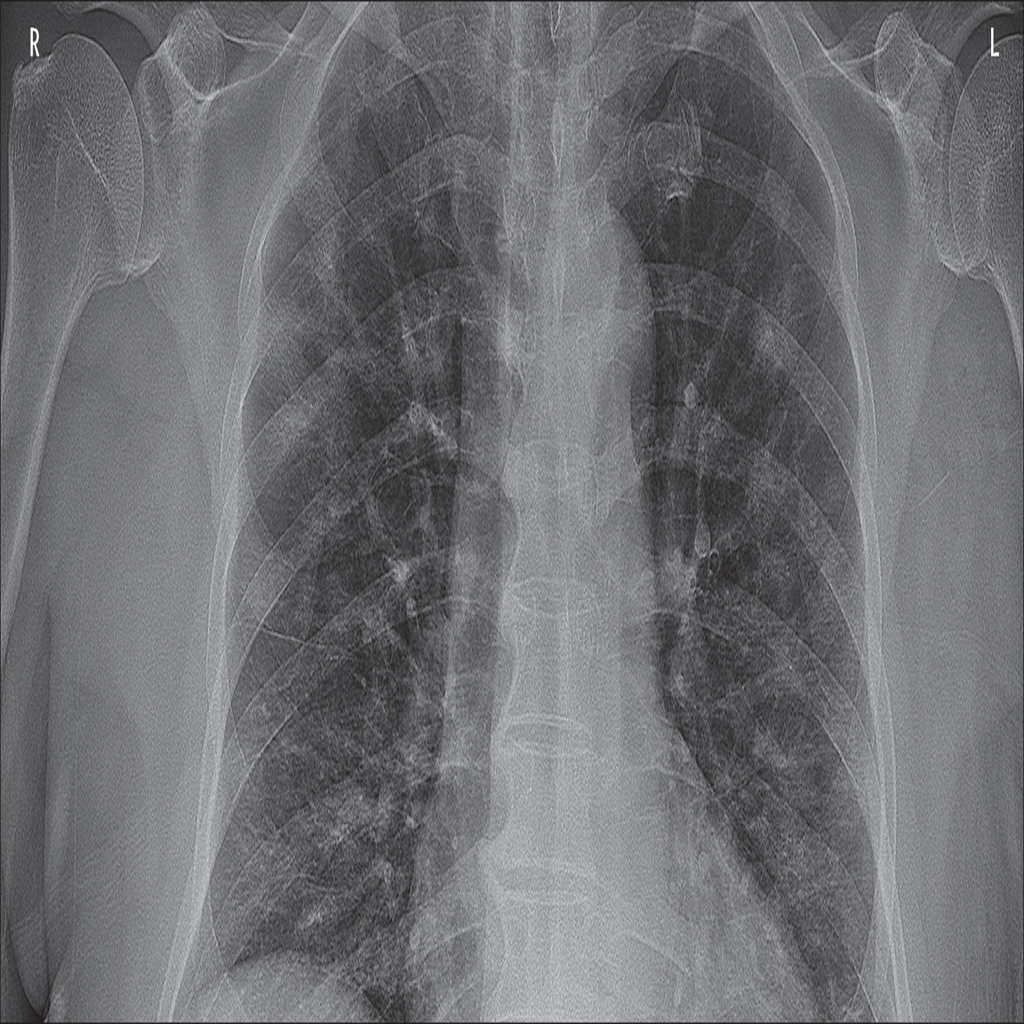

In [5]:
covid = list(DATA_DIR.glob('COVID-POSITIVE/*'))
PIL.Image.open(str(covid[0]))

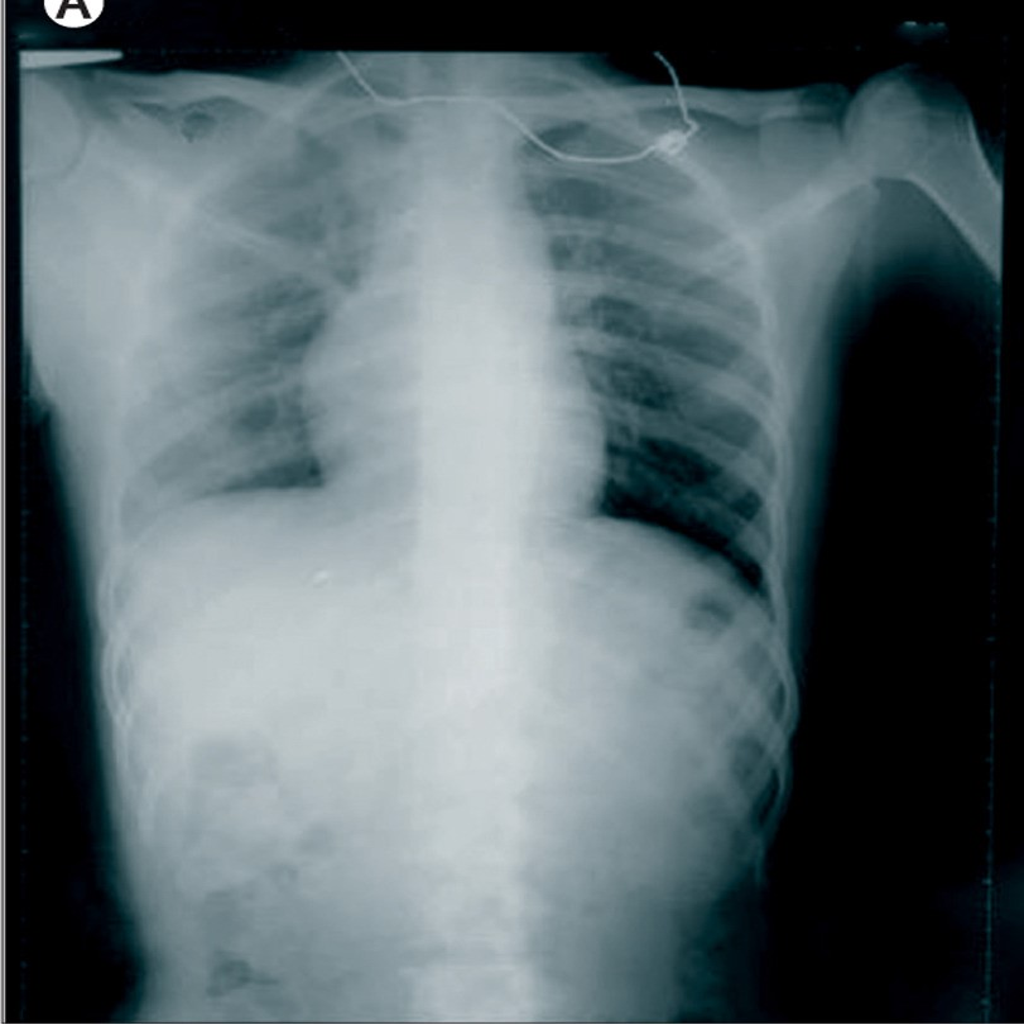

In [6]:
PIL.Image.open(str(covid[1]))

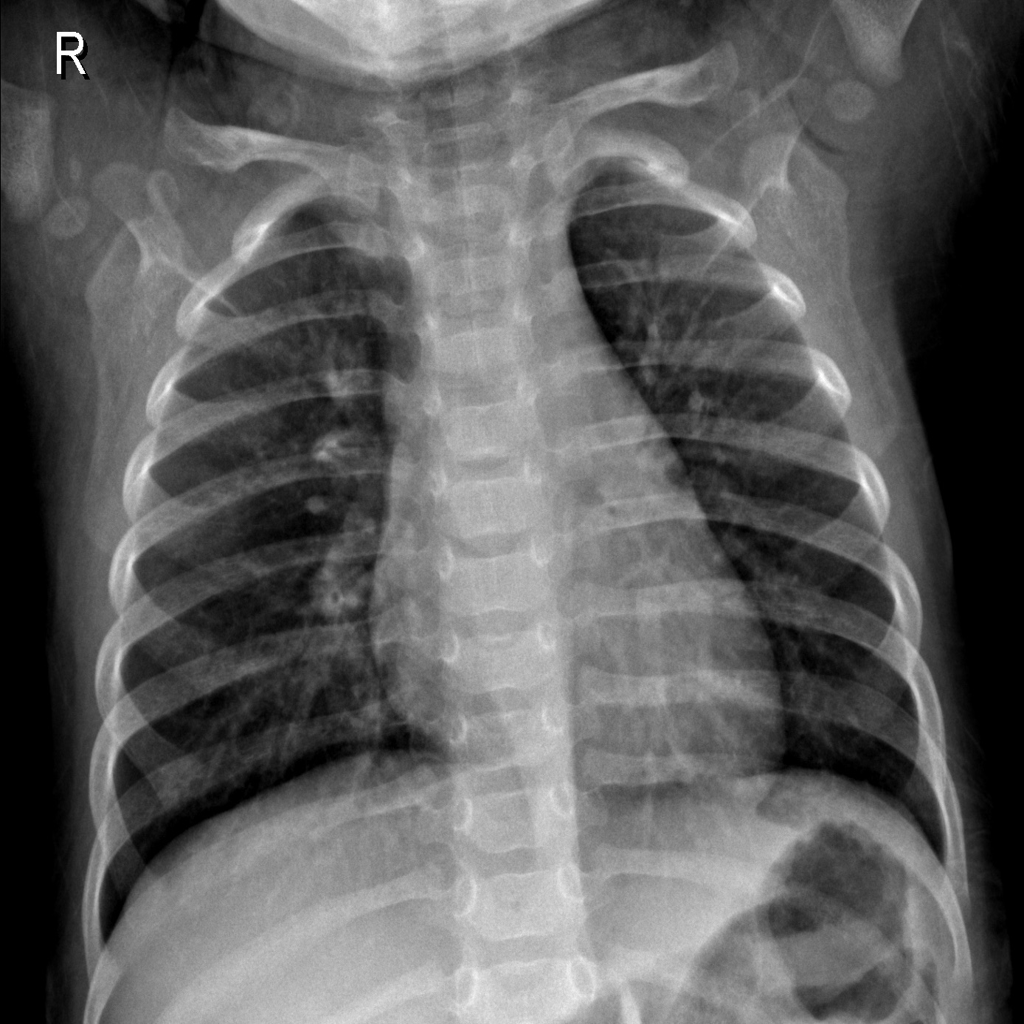

In [7]:
normal = list(DATA_DIR.glob('NORMAL/*'))
PIL.Image.open(str(normal[0]))

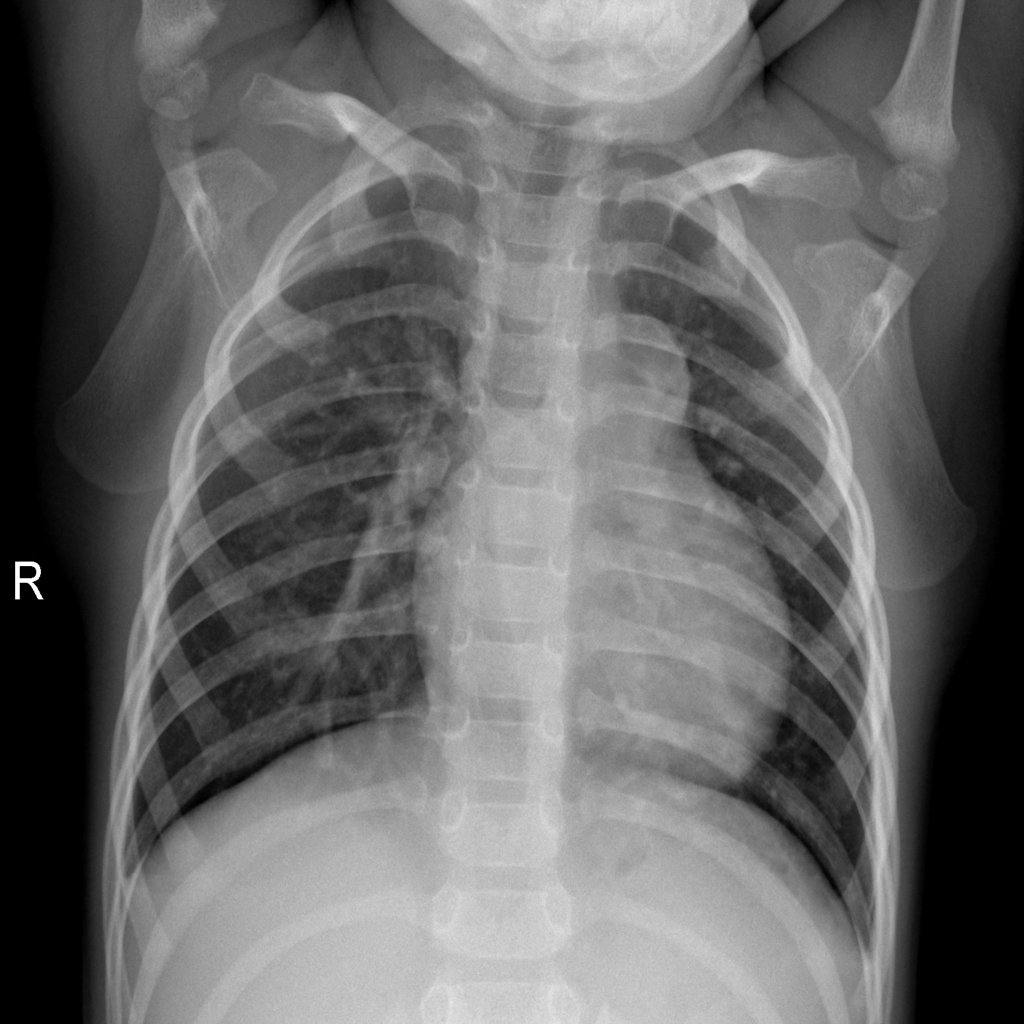

In [8]:
PIL.Image.open(str(normal[1]))

##### Preprocessing

In [9]:
batch_size = 10
img_height = 1024
img_width = 1024

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 435 files belonging to 2 classes.
Using 348 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 435 files belonging to 2 classes.
Using 87 files for validation.


In [30]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 3)
val_ds = val_ds.skip(val_batches // 3)

In [31]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 6
Number of test batches: 3


In [12]:
class_names = train_ds.class_names
print(class_names)

['COVID-POSITIVE', 'NORMAL']


### Visualizing Data

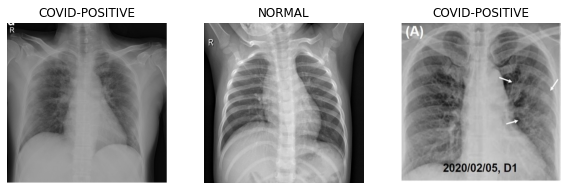

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(10, 1024, 1024, 3)
(10,)


**Configuring Dataset for performance**

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# val_ds.cache() This will ensure the dataset does not become a bottleneck while training your model
# .prefetch() overlaps data preprocessing and model execution while training.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardizing the data**

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


**Visualizing results**

**Data Augmentation**

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

**Augmented data**

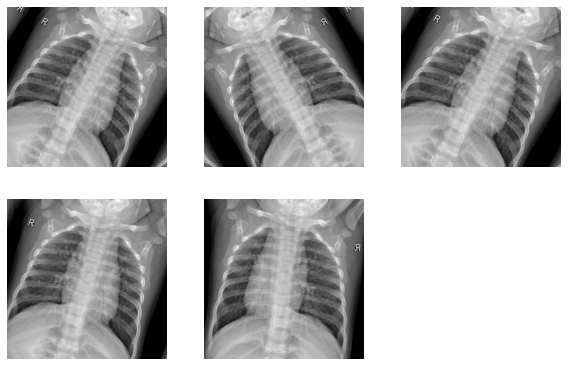

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(5):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [23]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1024, 1024, 3)     0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 1024, 1024, 3)     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1024, 1024, 16)    448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 512, 512, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 512, 512, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 256, 64)     

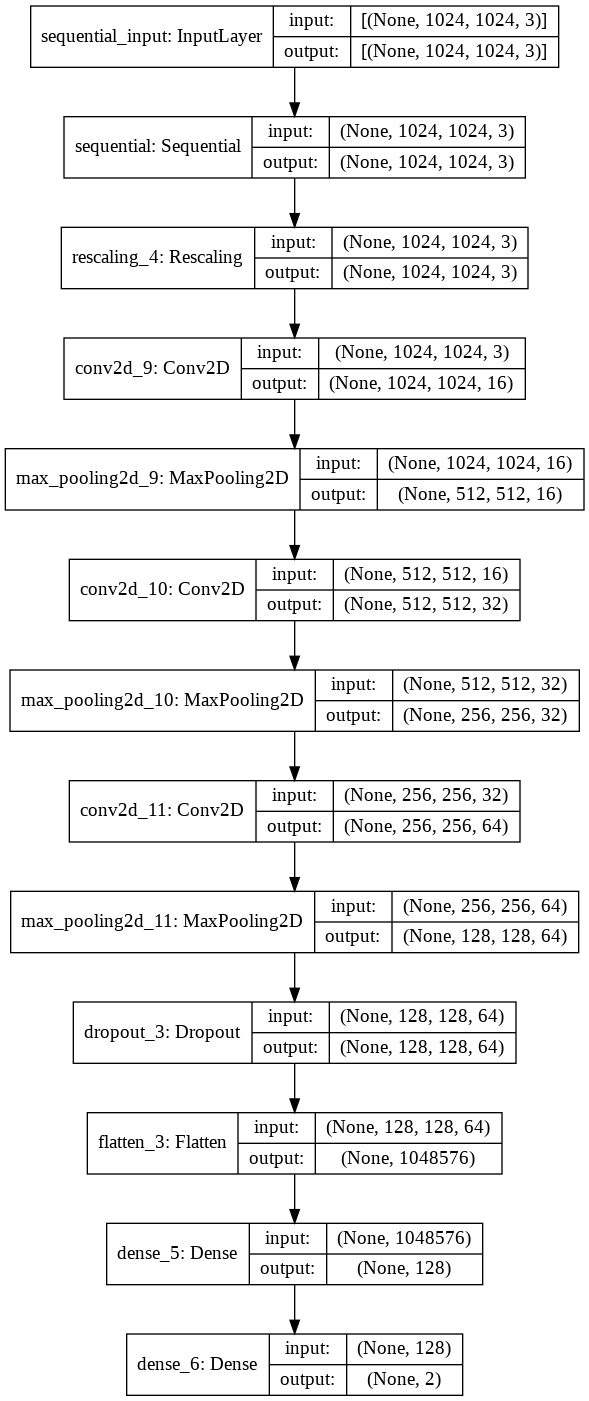

In [27]:
tf.keras.utils.plot_model(model, to_file="model_t.png", show_shapes=True)

In [25]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
35/35 [==============================] - 440s 12s/step - loss: 10.3764 - accuracy: 0.4843 - val_loss: 0.3585 - val_accuracy: 0.8966
Epoch 2/15
35/35 [==============================] - 420s 12s/step - loss: 0.4706 - accuracy: 0.7904 - val_loss: 0.2117 - val_accuracy: 0.8966
Epoch 3/15
35/35 [==============================] - 415s 12s/step - loss: 0.3118 - accuracy: 0.8540 - val_loss: 0.1978 - val_accuracy: 0.9195
Epoch 4/15
35/35 [==============================] - 413s 12s/step - loss: 0.2992 - accuracy: 0.8690 - val_loss: 0.1366 - val_accuracy: 0.9425
Epoch 5/15
35/35 [==============================] - 417s 12s/step - loss: 0.1708 - accuracy: 0.9334 - val_loss: 0.2109 - val_accuracy: 0.8851
Epoch 6/15
35/35 [==============================] - 413s 12s/step - loss: 0.2219 - accuracy: 0.9187 - val_loss: 0.1075 - val_accuracy: 0.9425
Epoch 7/15
35/35 [==============================] - 414s 12s/step - loss: 0.2289 - accuracy: 0.9290 - val_loss: 0.1550 - val_accuracy: 0.9195
Epoch

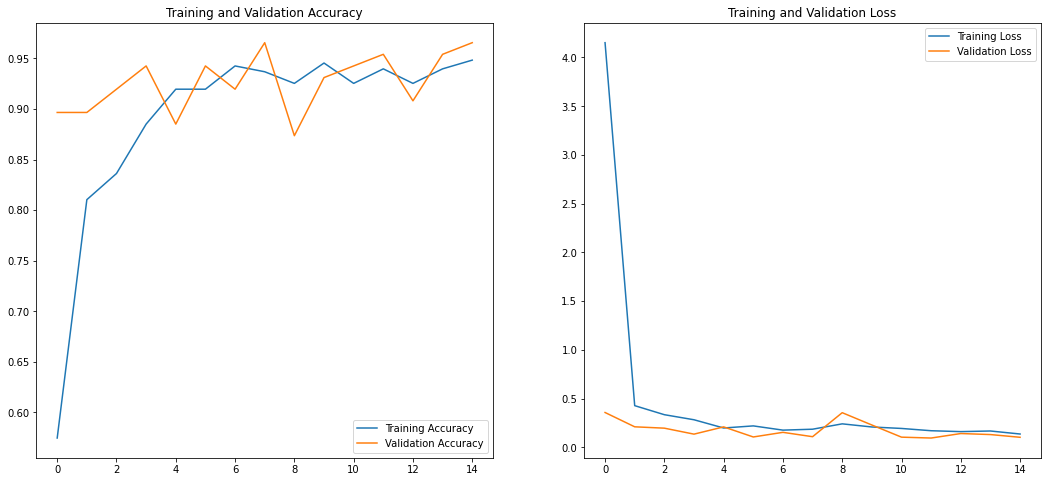

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
model.evaluate_generator(val_ds)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.10419859737157822, 0.9655172228813171]

In [29]:
model.evaluate(val_ds)

9/9 [==============================] - 23s 3s/step - loss: 0.1042 - accuracy: 0.9655


[0.10419859737157822, 0.9655172228813171]

In [ ]:
image_path = 'drive/MyDrive/FYP/n-Cov_pak dataset/img001.jpeg'

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to COVID-POSITIVE with a 98.57 percent confidence.


In [ ]:
image_path1 = 'drive/MyDrive/FYP/n-Cov_pak dataset/img007.jpeg'


img = keras.preprocessing.image.load_img(
    image_path1, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to COVID-POSITIVE with a 100.00 percent confidence.


In [ ]:
image_path2 = 'drive/MyDrive/FYP/n-Cov_pak dataset/IM-0022-0001.jpeg'


img = keras.preprocessing.image.load_img(
    image_path2, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to NORMAL with a 88.41 percent confidence.


In [ ]:
image_path3 = 'drive/MyDrive/FYP/IM-0001-0001.jpeg'


img = keras.preprocessing.image.load_img(
    image_path3, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to NORMAL with a 65.74 percent confidence.


In [ ]:
model.save("ncov_cls")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ncov_cls/assets
